In [1]:
# worldcam correction testing
# pulled from analyze_ephys.py
# TO DO: organize into a usable function at some point

In [2]:
cd t:\freely_moving_ephys\ephys_recordings\012821\EE8P6LT\fm1

t:\freely_moving_ephys\ephys_recordings\012821\EE8P6LT\fm1


In [3]:
#cd \\niell-v2-w7\T\freely_moving_ephys\ephys_recordings\021621\EE11P1RT\hf1_wn

In [4]:
#name_base = '021521_EE8P6LT_control_Rig2_fm1'
name_base = '012821_EE8P6LT_control_Rig2_fm1'
eye_file = name_base + '_Reye.nc'
world_file = name_base + '_world.nc'
ephys_file = name_base + '_ephys_merge.json'
imu_file = name_base + "_imu.nc"
speed_file = name_base + "_speed.nc"

#free_move = True; has_imu = True; has_mouse = False;
free_move= True; has_imu = True; has_mouse = False;
#stim_type = 'wn'

In [5]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
import subprocess
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.ndimage import shift as imshift
from scipy import signal
from sklearn.cluster import KMeans
from matplotlib.backends.backend_pdf import PdfPages

import scipy.sparse as sparse
import scipy.linalg as linalg
import scipy.stats as stats

from pyglmnet import GLM, simulate_glm

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [6]:
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])
sz = world_vid_raw.shape
downsamp = 1
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps.copy()
world_data
world_vid_raw = None

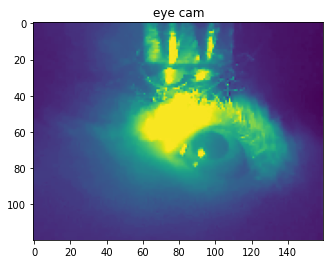

In [7]:
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
#omega = np.squeeze(np.array(eye_data['REYE_omega']))

In [8]:
print('opening ephys data')
ephys_data = pd.read_json(ephys_file)
ephys_data['spikeTraw'] = ephys_data['spikeT'].copy()

# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values

# get number of good units
n_units = len(goodcells)

opening ephys data


In [9]:
this_units = 0;
goodcells['spikeT'].iloc[0]


[0.6805333333,
 1.9886666667,
 2.0905666667,
 2.2627,
 2.7847,
 2.7998666667,
 2.8165,
 2.9331,
 3.1270666667,
 3.1438333333,
 3.2416333333,
 3.3884333333,
 3.491,
 3.5107333333,
 3.5658666667,
 3.6448333333000003,
 3.7044333333,
 3.8277333333,
 3.8471666667,
 3.8959,
 3.9384666667,
 3.9908,
 4.0501,
 4.1991666667,
 4.2449,
 4.2556,
 4.7156666667,
 4.8631333333,
 5.1908333333,
 5.5058,
 5.5675333333,
 5.598,
 5.6661666667,
 5.7003,
 5.8429333332999995,
 5.9119666667,
 6.0378,
 6.088,
 6.1027666667,
 6.2211,
 6.2964,
 6.3001000000000005,
 6.3290333333,
 6.3468333333,
 6.3492666667,
 6.3582666667,
 6.4147666667,
 6.4470333333,
 6.4615333333,
 6.4972666667,
 6.5481333333,
 6.5647,
 6.5847333333,
 6.5956666667,
 6.6403333333,
 6.7266,
 6.7701,
 6.9240333333,
 7.0898666667,
 7.1075666667,
 8.3768666667,
 8.3990666667,
 8.417033333300001,
 8.7775,
 8.8084,
 8.8854666667,
 8.9017666667,
 8.9089666667,
 8.9137333333,
 8.9259333333,
 8.9335,
 9.0534,
 9.135,
 9.5474666667,
 9.8960666667,
 9.979

In [10]:
if free_move & has_imu:
    imu_data = xr.open_dataset(imu_file)
    acc_chans = imu_data.IMU_data
    gx = np.array(acc_chans.sel(channel='gyro_x'))
    gy = np.array(acc_chans.sel(channel='gyro_y'))
    gz = np.array(acc_chans.sel(channel='gyro_z'))

In [11]:
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
if free_move & has_imu:
    accTraw = imu_data.timestamps-ephysT0
if (free_move==False) & has_mouse:
    speedT = spd_tstamps-ephysT0
eyeT, worldT

(<xarray.DataArray 'timestamps' (frame: 251326)>
 array([-8.65951750e-01, -8.49836250e-01, -8.33797750e-01, ...,
         4.19247359e+03,  4.19248963e+03,  4.19250567e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 251321 251322 251323 251324 251325
     timestamps  (frame) float64 4.502e+04 4.502e+04 ... 4.921e+04 4.921e+04,
 <xarray.DataArray 'timestamps' (frame: 251329)>
 array([-9.05823750e-01, -8.88697250e-01, -8.72658750e-01, ...,
         4.19244124e+03,  4.19245773e+03,  4.19247377e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 251324 251325 251326 251327 251328
     timestamps  (frame) float64 4.502e+04 4.502e+04 ... 4.921e+04 4.921e+04)

In [12]:
# some video timestamps are out of order!!
order = np.argsort(np.array(worldT))
worldT = worldT[order].copy()
world_vid = world_vid[order,:,:].copy()

In [13]:
offset0 = 0.1;
drift_rate = -0.1/1000;
for i in range(len(ephys_data)):
    ephys_data['spikeT'][i] = np.array(ephys_data['spikeTraw'].iloc[i]) - (offset0 + np.array(ephys_data['spikeTraw'].iloc[i]) *drift_rate)
if free_move & has_imu:
    accT= accTraw - (offset0 + accTraw*drift_rate)
goodcells = ephys_data.loc[ephys_data['group']=='good']


<ipython-input-13-f261d47113ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ephys_data['spikeT'][i] = np.array(ephys_data['spikeTraw'].iloc[i]) - (offset0 + np.array(ephys_data['spikeTraw'].iloc[i]) *drift_rate)


Text(0, 0.5, 'phi')

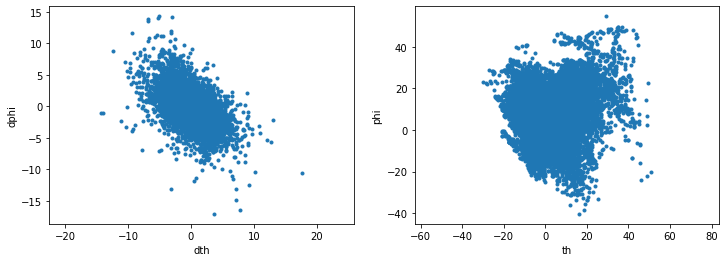

In [14]:
th_interp = interp1d(eyeT,th,bounds_error = False)
phi_interp = interp1d(eyeT, phi, bounds_error = False)
#omega_interp = interp1d(eyeT, omega, bounds_error = False)
dth = np.diff(th_interp(worldT))
dphi = np.diff(phi_interp(worldT))

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(dth[0:60*60*5],dphi[0:60*60*5],'.')
plt.axis('equal')
plt.xlabel('dth')
plt.ylabel('dphi')

plt.subplot(1,2,2)
plt.plot(th[0:60*60*5],phi[0:60*60*5],'.')
plt.axis('equal')
plt.xlabel('th')
plt.ylabel('phi')

In [15]:
# get worldcam correction based on eye-movement vs frameshift regression
if free_move:
    print('getting worldcam correction')
    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_TRANSLATION
    max_frames = 60*60
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);
    warp_all = np.zeros((6,max_frames))
    # get shift between adjacent frames
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        try: 
            (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
            xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]
            warp_all[:,i] = np.reshape(warp_matrix,6)
        except:
            cc[i] = np.nan;
            xshift[i]=np.nan; yshift[i] = np.nan;
            warp_all[:,i] = np.nan

  1%|▌                                                                              | 27/3600 [00:00<00:13, 258.91it/s]

getting worldcam correction


100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [02:34<00:00, 23.25it/s]


[[ 9.9999994e-01  3.8160500e-04  5.9870048e+00]
 [-3.8160500e-04  9.9999994e-01  3.0410135e+00]]


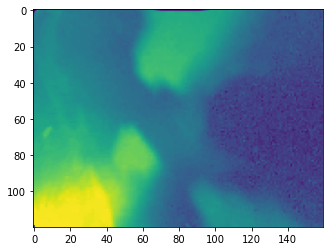

In [16]:
a = world_vid[0,:,:]; b= np.roll(a,(3,6),axis = (0,1))
plt.imshow(b)
warp_matrix = np.eye(2, 3, dtype=np.float32)
number_of_iterations = 5000
termination_eps = 1e-4
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
warp_mode = cv2.MOTION_EUCLIDEAN
(ccjunk, warp_matrix) = cv2.findTransformECC (a,b,warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
print(warp_matrix)
c = np.roll(b,(-3,-6), axis = (0,1))
plt.imshow(c)

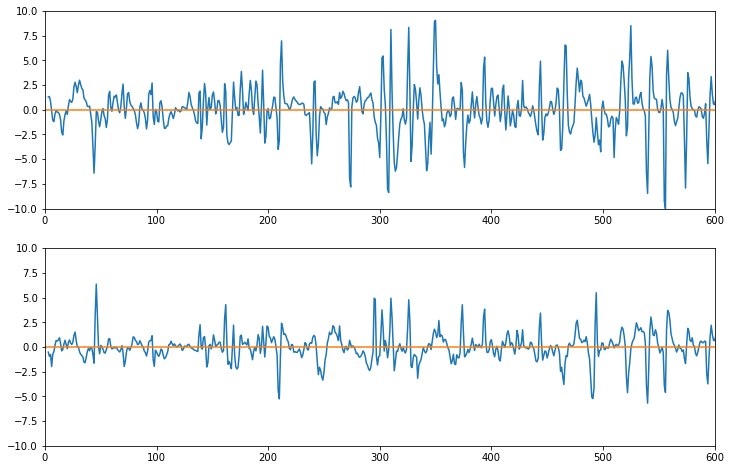

In [17]:
if free_move:
    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    plt.plot(dth[0:max_frames])
    plt.plot(warp_all[1,0:max_frames]*50)
    plt.xlim(0,600)
    plt.ylim(-10,10)
    
    plt.subplot(2,1,2)
    plt.plot(-dphi[0:max_frames])
    plt.plot(warp_all[1,0:max_frames]*50)
    plt.xlim(0,600)
    plt.ylim(-10,10)


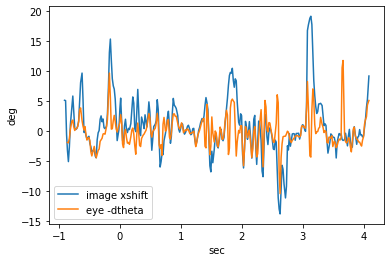

In [647]:
maxt = 300
if free_move:
    plt.plot(worldT[0:maxt],xshift[0:maxt],label = 'image xshift')
    plt.plot(worldT[0:maxt],-dth[0:maxt]*1.5,label = 'eye -dtheta')
    #plt.xlim([100,300])
    plt.legend();
    plt.xlabel('sec'); plt.ylabel('deg')

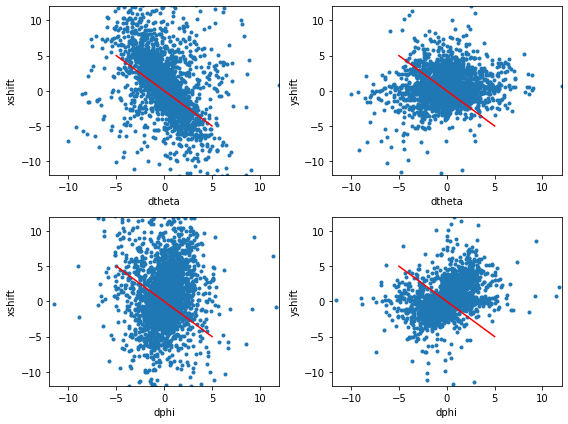

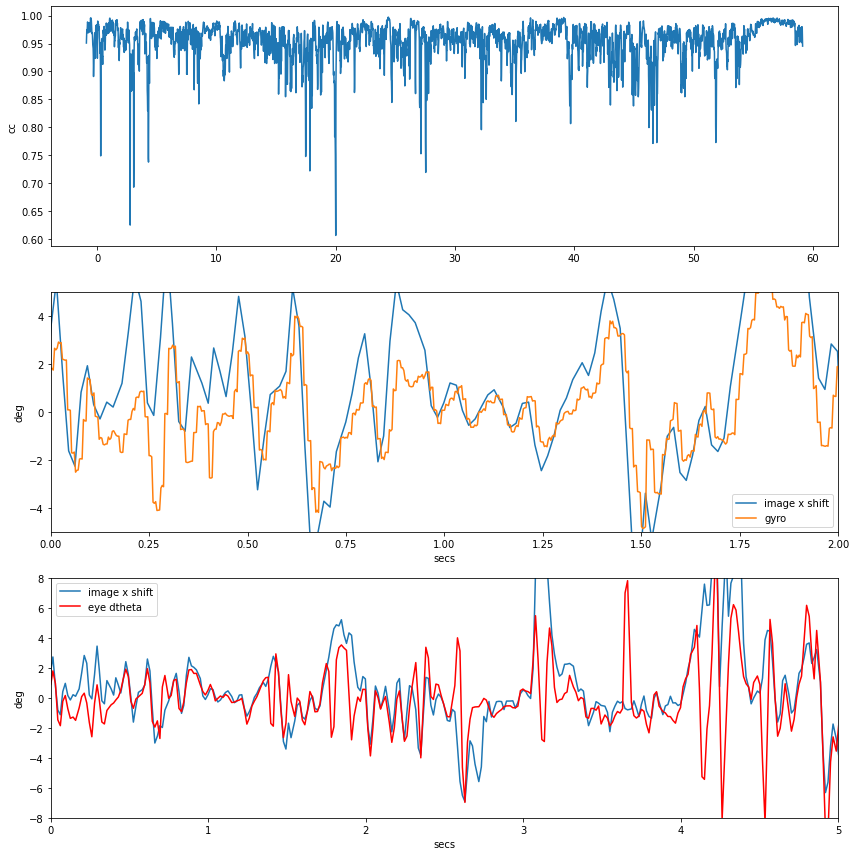

In [637]:
if free_move:
    plt.figure(figsize = (8,6))
    plt.subplot(2,2,1)
    plt.plot(dth[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dtheta'); plt.ylabel('xshift')
    plt.subplot(2,2,2)
    plt.plot(dth[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dtheta'); plt.ylabel('yshift')
    plt.subplot(2,2,3)
    plt.plot(dphi[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dphi'); plt.ylabel('xshift')
    plt.subplot(2,2,4)
    plt.plot(dphi[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dphi'); plt.ylabel('yshift')
    plt.tight_layout()

    plt.figure(figsize = (12,12))
    plt.subplot(3,1,1)
    plt.plot(worldT[0:max_frames],cc); plt.ylabel('cc')

    plt.subplot(3,1,2)
    plt.plot(worldT[0:max_frames],xshift, label = 'image x shift');
    plt.plot(accT,(gz-np.mean(gz))*7.5, label = 'gyro')
    #plt.plot(worldT[0:max_frames],yshift, label = 'y');
    #plt.plot(eyeT[0:-1],-dEye,label = 'eye dtheta')
    plt.xlim(0,2); plt.ylim(-5,5)
    plt.xlabel('secs'); plt.ylabel('deg')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(worldT[0:max_frames],0.5*xshift, label = 'image x shift');
    #plt.plot(accT,-(gz-2.9)*7.5, label = 'gyro')
    #plt.plot(worldT[0:max_frames],yshift, label = 'y');
    plt.plot(worldT[0:-1],-dth,'r',label = 'eye dtheta', alpha = 1)
    plt.xlim(0,5); plt.ylim(-8,8)
    plt.xlabel('secs'); plt.ylabel('deg')
    plt.legend()
    plt.tight_layout()




[-1.33139436  0.20240829] 0.4039944273117062
[0.43161144 1.03718537] 0.44548963088586646


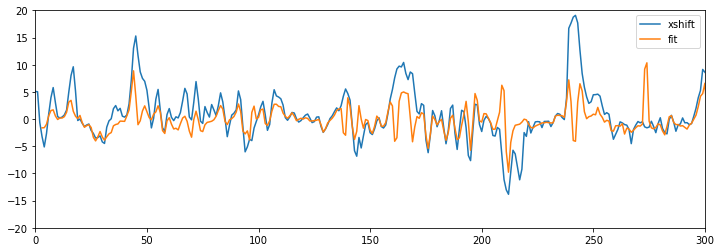

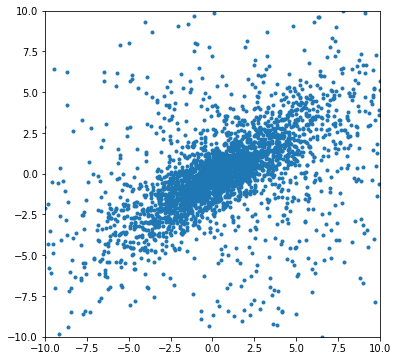

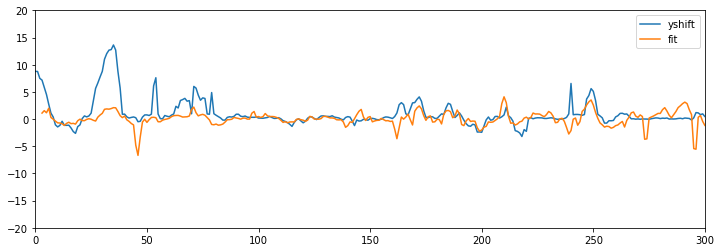

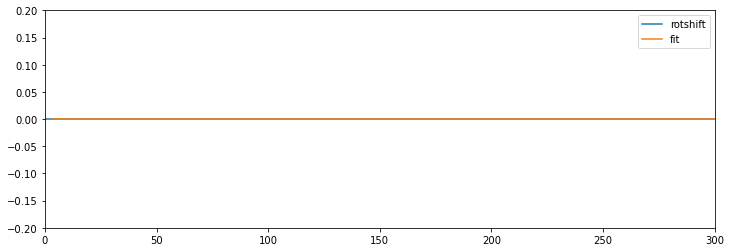

In [648]:
if free_move:
    xmodel = LinearRegression()
    ymodel = LinearRegression()
    rotmodel = LinearRegression()
    
    eyeData = np.zeros((max_frames,2))
    eyeData[:,0] = dth[0:max_frames];
    eyeData[:,1] = dphi[0:max_frames];
    
    rotshiftdata = warp_all[1,0:max_frames];
    xshiftdata = xshift[0:max_frames];
    yshiftdata = yshift[0:max_frames];
    
    usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1]) & (cc>0.95)  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2) & (np.abs(xshiftdata)<5) & (np.abs(yshiftdata)<5)
    
    # fit xshift
    
    xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])
    xmap = xmodel.coef_;
    xrscore = xmodel.score(eyeData[usedata,:],xshiftdata[usedata])
    print(xmap, xrscore)

    xfit = xmap[0]* dth + xmap[1]*dphi;
    plt.figure(figsize = (12,4))
    plt.plot(xshiftdata, label = 'xshift')
    plt.plot(xfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-20,20)

    plt.figure(figsize = (6,6))
    plt.plot(xshiftdata,xfit[0:len(xshiftdata)],'.'); plt.xlim(-10,10); plt.ylim(-10,10)

    # fit yshift
    ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])

    ymap = ymodel.coef_;
    yrscore = ymodel.score(eyeData[usedata,:],yshiftdata[usedata])

    yfit = ymap[0] * dth + ymap[1]*dphi
    plt.figure(figsize = (12,4))
    plt.plot(yshiftdata, label = 'yshift')
    plt.plot(yfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-20,20)

    print(ymap,yrscore)
    
    # fit rotation shift
    rotmodel.fit(eyeData[usedata,:],rotshiftdata[usedata])

    rotmap = rotmodel.coef_;
    rotrscore = rotmodel.score(eyeData[usedata,:],rotshiftdata[usedata])

    rotfit = rotmap[0] * dth + rotmap[1]*dphi
    plt.figure(figsize = (12,4))
    plt.plot(rotshiftdata, label = 'rotshift')
    plt.plot(rotfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-0.2,0.2)


    #print(rotmap,rotrscore)

else:
    xmap = [-1.33,  0.202]
    ymap =[0.431,  1.07]  # values for 012821 fm


In [20]:
print(xmap,ymap)

[-1.33139436  0.20240829] [0.43161144 1.03718537]


In [21]:
# set up interpolators for eye and world videos
eyeInterp = interp1d(eyeT,eye_vid,axis=0)
worldInterp = interp1d(worldT,world_vid,axis=0)

getting eye correction movie


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.45it/s]


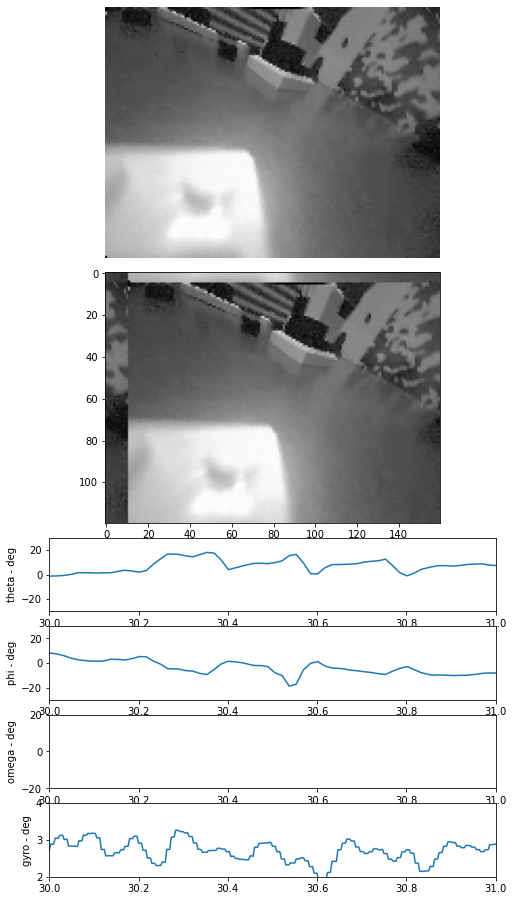

In [22]:
if free_move:
    # eye correction movie
    print('getting eye correction movie')
    tr = [30,31]
    fig = plt.figure(figsize = (8,16))
    gs = fig.add_gridspec(10,1)
    axEye = fig.add_subplot(gs[0,0])
    axWorld = fig.add_subplot(gs[0:3,:])
    axWorldFix = fig.add_subplot(gs[3:6,:])

    axTheta = fig.add_subplot(gs[6,:])
    axPhi = fig.add_subplot(gs[7,:])
    axOmega = fig.add_subplot(gs[8,:])
    axGyro = fig.add_subplot(gs[9,:])

    th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
    phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

    axTheta.plot(eyeT,th)
    axTheta.set_xlim(tr[0],tr[1]); 
    axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

    axPhi.plot(eyeT,phi)
    axPhi.set_xlim(tr[0],tr[1]); 
    axPhi.set_ylabel('phi - deg'); axPhi.set_ylim(-30,30)

    #axOmega.plot(eyeT,omega)
    axOmega.set_xlim(tr[0],tr[1]); 
    axOmega.set_ylabel('omega - deg'); axOmega.set_ylim(-20,20)

    if free_move & has_imu:
        axGyro.plot(accT,gz)
        axGyro.set_xlim(tr[0],tr[1]); 
        axGyro.set_ylabel('gyro - deg'); axGyro.set_ylim(2,4)

    thInterp =interp1d(eyeT,th)
    phiInterp =interp1d(eyeT,phi)
    pix_per_deg = 1.6

    vidfile = name_base +'_corrected.mp4'
    # now animate
    writer = FFMpegWriter(fps=30)
    with writer.saving(fig, vidfile, 100):
    #    for t in np.arange(tr[0],tr[1],1/30):
        for t in tqdm(worldT[(worldT>tr[0]) & (worldT<tr[1])]):        
            # show eye and world frames
            axEye.cla(); axEye.axis('off'); 
            axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
            #axEye.set_xlim(0,160); axEye.set_ylim(0,120)

            world = worldInterp(t)
            axWorld.cla(); axWorld.axis('off'); 
            axWorld.imshow(world,'gray',vmin=0,vmax=255,aspect = "equal")
            #om = np.radians(omega_interp(t))
            #axWorld.plot([80 - 32*np.cos(om), 80 + 32*np.cos(om)], [80 + 32*np.sin(om), 80 - 32*np.sin(om)])

            worldFix= np.roll(world,(-np.int8(thInterp(t)*ymap[0] + phiInterp(t)*ymap[1]),-np.int8(thInterp(t)*xmap[0] + phiInterp(t)*xmap[1])),axis = (0,1))
            axWorldFix.imshow(worldFix,'gray',vmin=0, vmax = 255, aspect = 'equal')

            #plot line for time, then remove
            ln1 = axTheta.vlines(t,-0.5,30,'b')
            ln2 = axPhi.vlines(t,-0.5,30,'b')
            writer.grab_frame()
            ln1.remove()
            ln2.remove()



In [261]:
eyeR = eye_params.sel(ellipse_params = 'longaxis').copy()
rInterp = interp1d(eyeT,eyeR, bounds_error = False)

thInterp =interp1d(eyeT,th, bounds_error = False)
phiInterp =interp1d(eyeT,phi, bounds_error = False)
thWorld = thInterp(worldT)
phiWorld = phiInterp(worldT)

In [24]:
ephys_data['worldR'] = nan
ephys_data['worldR'] = ephys_data['worldR'].astype(object)
worldBins = np.append(worldT,worldT[-1]+1/60)
for i,ind in enumerate(ephys_data.index):
    ephys_data.at[ind,'worldR'],bins = np.histogram(ephys_data.at[ind,'spikeT'],worldBins)
    ephys_data.at[ind,'worldR'] = ephys_data.at[ind,'worldR'] /np.diff(worldBins)
goodcells = ephys_data.loc[ephys_data['group']=='good']

'shifting worldcam'

'applying gamma to camera'

'shifting worldcam for eyes'

100%|█████████████████████████████████████████████████████████████████████████| 251329/251329 [09:26<00:00, 443.51it/s]


'normalizing world cam'

'setting up worldcam interpolator'

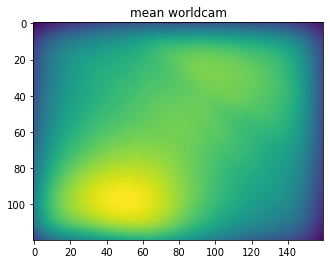

In [131]:
display('shifting worldcam')
xcorrection = xmap.copy()
ycorrection = ymap.copy()

#xcorrection = [0,0]; ycorrection= [0,0]

display('applying gamma to camera')
cam_gamma = 1
world_norm = (world_vid/255)#**cam_gamma

thInterp =interp1d(eyeT,th, bounds_error = False)
phiInterp =interp1d(eyeT,phi, bounds_error = False)

display('shifting worldcam for eyes')
thWorld = thInterp(worldT)
phiWorld = phiInterp(worldT)
for f in tqdm(range(np.shape(world_vid)[0])):
    world_norm[f,:,:] = imshift(world_norm[f,:,:],(-np.int8(thInterp(worldT[f])*ycorrection[0] + phiInterp(worldT[f])*ycorrection[1]),-np.int8(thInterp(worldT[f])*xcorrection[0] + phiInterp(worldT[f])*xcorrection[1])))

display('normalizing world cam')
plt.imshow(np.mean(world_norm,axis=0)); plt.title('mean worldcam')
std_im = np.std(world_norm,axis=0)
std_im[std_im<10/255] = 10/255
img_norm = (world_norm-np.mean(world_norm,axis=0))/std_im
img_norm = img_norm * (std_im>10/255)
world_norm = None;

display('setting up worldcam interpolator')
#img_norm[img_norm<-2] = -2
#movInterp = interp1d(worldT,img_norm,axis=0, kind = 'nearest')

In [480]:
# get timing
print('get timing')
model_dt = 0.025;
model_t = np.arange(0,np.max(worldT),model_dt)
model_nsp = np.zeros((n_units,len(model_t)))

# get spikes / rate
print('get spikes')
bins = np.append(model_t,model_t[-1]+model_dt)
for i,ind in enumerate(goodcells.index):
    model_nsp[i,:],bins = np.histogram(ephys_data.at[ind,'spikeT'],bins)
model_R = model_nsp/model_dt;

# get video
print('creating interpolator')
interp = interp1d(worldT + model_dt/2,img_norm,axis = 0, bounds_error = False)
#model_vid = np.zeros((len(model_t),np.shape(img_norm)[1],np.shape(img_norm)[2]))
downsamp = 0.5

print('downsampling')
testimg = img_norm[0,:,:]
testimg = cv2.resize(testimg,(int(np.shape(testimg)[1]*downsamp), int(np.shape(testimg)[0]*downsamp)))
#testimg = testimg[15:45:2,30:70:2];
testimg = testimg[5:55:2,5:75:2];

#testimg = testimg[::2,::2];

#model_vid_sm = np.zeros((len(model_t),np.int(np.shape(img_norm)[2]*np.shape(img_norm)[1]*downsamp**2)))
model_vid_sm = np.zeros((len(model_t),np.int(np.shape(testimg)[0]*np.shape(testimg)[1])))


for i in tqdm(range(len(model_t))):
    model_vid = interp(model_t[i])
    smallvid = cv2.resize(model_vid,(np.int(np.shape(img_norm)[2]*downsamp),np.int(np.shape(img_norm)[1]*downsamp)))

    #smallvid = smallvid[15:45:2,30:70:2];
    #smallvid = smallvid[::2,::2];
    smallvid = smallvid[5:55:2,5:75:2];
    #smallvid = smallvid-np.mean(smallvid)
    model_vid_sm[i,:] = np.reshape(smallvid,np.shape(smallvid)[0]*np.shape(smallvid)[1])

#std_sm = np.std(model_vid_sm,axis=0)
#goodpts = np.where(std_sm>0.8)
#model_vid_sm_good = model_vid_sm[:,goodpts[0]]
#model_vid_crop = model_vid_sm[:,15:28,5:30]
#model_vid_sm_good = np.reshape(model_vid_crop,(n_units,np.int(np.shape(model_vid_crop)[1]*np.shape(model_vid_crop)[2])))
                        
    
#get eye position
print('get eye')
model_th = thInterp(model_t+model_dt/2)
model_phi = phiInterp(model_t+model_dt/2)
dthInterp = interp1d(eyeT[:-1],np.diff(th))
model_dth = dthInterp(model_t)
model_r = rInterp(model_t+model_dt/2)

# get gyro z
if free_move:
    print('get gyro')
    interp = interp1d(accT,(gz-np.mean(gz))*7.5,bounds_error=False)
    model_gz = interp(model_t)
    model_active = np.convolve(np.abs(model_gz),np.ones(np.int(1/model_dt)),'same')
    
    # sum and difference of head/eye movements
    model_dgz = model_gz + model_dth;    
    model_dcomp = model_gz -model_dth;
    


get timing
get spikes
creating interpolator


  0%|                                                                                       | 0/167699 [00:00<?, ?it/s]

downsampling


100%|████████████████████████████████████████████████████████████████████████| 167699/167699 [00:28<00:00, 5934.88it/s]


get eye
get gyro


(-20.0, 20.0)

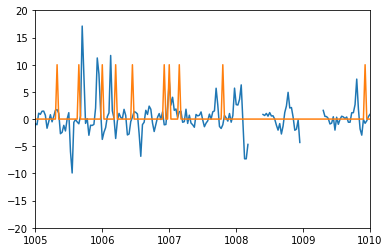

In [545]:
dthInterp = interp1d(eyeT[:-1],np.diff(th),'nearest')
model_dth = dthInterp(model_t)
#plt.plot(model_gz[::100],model_dth[::100],'.')
#plt.plot([-10,10],[10,-10])
#plt.plot(model_t,model_gz); plt.plot(model_t,-model_dth)
#plt.plot(model_t,0.5*(model_gz-model_dth))
plt.plot(model_t,model_gz+model_dth)
plt.plot(model_t,model_nsp[0,:]*10)
plt.xlim([1005,1010])
plt.ylim([-20,20])
#plt.plot(model_t,model_dth)
#plt.plot(eyeT[:-1],np.diff(th))
#plt.plot(accT,-(gz-np.mean(gz))*7.5)
#plt.plot(model_t,-model_gz)

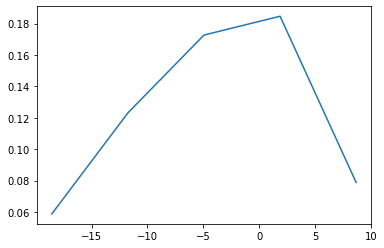

In [546]:
model_r = rInterp(model_t)
binned_th,bins,junk = stats.binned_statistic(model_gz[np.isfinite(model_gz)],model_nsp[0,np.isfinite(model_gz)],'mean',5)
plt.plot(bins[:-1],binned_th)
#plt.hist(model_gz)

(array([2.402e+03, 2.268e+03, 3.092e+03, 4.271e+03, 4.599e+03, 3.806e+03,
        3.173e+03, 3.229e+03, 4.091e+03, 5.237e+03, 6.256e+03, 7.359e+03,
        7.860e+03, 8.107e+03, 8.256e+03, 8.552e+03, 8.627e+03, 8.756e+03,
        8.690e+03, 8.660e+03, 7.927e+03, 7.131e+03, 6.106e+03, 5.305e+03,
        4.390e+03, 3.937e+03, 3.159e+03, 2.526e+03, 2.008e+03, 1.705e+03,
        1.447e+03, 1.067e+03, 8.620e+02, 6.520e+02, 5.530e+02, 4.470e+02,
        3.080e+02, 2.120e+02, 1.270e+02, 1.240e+02, 1.000e+02, 7.600e+01,
        5.400e+01, 4.300e+01, 3.700e+01, 3.200e+01, 2.200e+01, 1.900e+01,
        8.000e+00, 4.000e+00]),
 array([  1.34500182,   4.44500529,   7.54500876,  10.64501223,
         13.7450157 ,  16.84501917,  19.94502264,  23.04502611,
         26.14502957,  29.24503304,  32.34503651,  35.44503998,
         38.54504345,  41.64504692,  44.74505039,  47.84505386,
         50.94505733,  54.0450608 ,  57.14506426,  60.24506773,
         63.3450712 ,  66.44507467,  69.54507814,  72.64

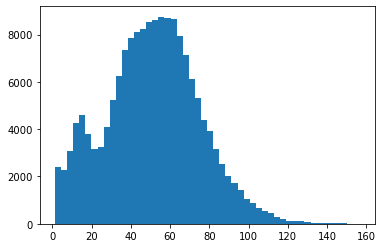

In [547]:
plt.hist(model_active,50)

In [ ]:
# set up eye design matrix
interval = 1;
nt = 20;
ngroup = 2;
eyeDesign = np.zeros((len(model_t),ngroup*(interval*nt+1)));
model_dth = np.diff(model_th)
for t in range(interval*nt,len(model_th)- interval*nt):  # use np.roll instead, with roll = -range : interval, range
    eyeDesign[t,:nt+1] =  model_dth[range(np.int(t-nt/2),np.int(t+nt/2+1)) ] - model_gz[range(np.int(t-nt/2),np.int(t+nt/2+1))] 
    eyeDesign[t,nt+1:2*(nt+1)] =  model_dth[range(np.int(t-nt/2),np.int(t+nt/2+1)) ] + model_gz[range(np.int(t-nt/2),np.int(t+nt/2+1))]
plt.imshow(eyeDesign[1:200,:],aspect = 'auto'); plt.colorbar()
eyeDesign[np.isnan(eyeDesign)] = 0
trange = np.array(range(np.int(-nt/2),np.int(nt/2+1)))

In [ ]:
trangeAll = np.append(trange,trange)
for unit in range(n_units): 
    eyePos = eyeDesign.copy();   eyePos[eyePos<0]=0; #eyePos = (eyePos>3);
    eyePos = eyePos - np.mean(eyePos)
    eyePos = np.append(eyePos,np.ones((len(model_t),1)), axis = 1) # append column of ones
    sta_ridge = np.linalg.solve(eyePos.T@eyePos, eyePos.T@model_nsp[unit,:])
    plt.figure(figsize = (16,4))
    plt.subplot(1,3,1)
    plt.plot(-trangeAll*model_dt,sta_ridge[:-1]*100)
    sta= eyePos.T@model_nsp[unit,:]/np.sum(model_nsp[unit,:])  
    plt.plot(-trangeAll*model_dt,sta[:-1],'.')
    plt.title(str(np.mean(model_nsp[unit,:])))
    plt.subplot(1,3,2)
   # plt.plot(model_t,eyePos@sta_ridge); plt.plot(model_t,model_nsp[unit,:]);plt.xlim([1000,1010]);
   # plt.title(str(np.var(model_nsp[unit,:])))
    
    sp_smooth = (np.convolve(model_nsp[unit,:],np.ones(60),'same'))
    pred_smooth = (np.convolve(eyePos@sta_ridge,np.ones(60),'same'))
    err = np.mean((sp_smooth-pred_smooth)**2)
    plt.title('var = '+ str(np.var(sp_smooth))  + 'err = ' + str(err))


    plt.plot(sp_smooth)
    plt.plot(pred_smooth)
    plt.xlim(0,3600)
    
    plt.subplot(1,3,3)
    binned_rate, bins,junk = stats.binned_statistic(eyePos@sta_ridge,model_nsp[unit,:],'mean',10)
    plt.plot(bins[:-1],binned_rate); plt.title(str(np.mean((eyePos@sta_ridge - model_nsp[unit,:])**2)))

In [756]:
# add additional parameters
nT = np.shape(model_nsp)[1]
nparams = 0;
#params = np.zeros((nT,nparams))
#params = eyePos[:,:-3]
#params[:,0] = model_dth.copy();
np.shape(params)

(167699, 40)

In [757]:
# set up design matrix with video + params
use = np.where((np.abs(model_th)<50) & (np.abs(model_phi)<50)& (model_active>2.5) )[0]
#use = np.where((np.abs(model_th)<5) & (model_active>5))[0]

nT = np.shape(model_nsp)[1]
x = model_vid_sm.copy();

#subtract mean - necessary?
mn_img = np.mean(x,axis=0)
x = x-mn_img

if nparams>0:
    x = np.append(x,params,axis = 1)
x = np.append(x,np.ones((nT,1)), axis = 1) # append column of ones
x = x[use,:]
nks  = np.shape(smallvid); nk = nks[0]*nks[1];
nks



(25, 35)

In [758]:
np.shape(x)

(163043, 876)

In [760]:
#nks = [10, 10]; nk = nks[0]*nks[1];
consecutive = np.ones((nk,1))
consecutive[nks[1]-1::nks[1]] = 0;
diff = np.zeros((1,2)); diff[0,0] = -1; diff[0,1]= 1;
Dxx = sparse.diags((consecutive @ diff).T, np.array([0, 1]), (nk-1,nk))
Dxy = sparse.diags((np.ones((nk,1))@ diff).T, np.array([0, nks[1]]), (nk - nks[1], nk))

Dx = Dxx.T @ Dxx + Dxy.T @ Dxy
Dx

if nparams>0:
    Dx1 = sparse.diags((np.ones((nparams,1))@diff).T,np.array([0,1]),(nparams-1,nparams));
    Dx_params = Dx1.T@Dx1
    np.shape(Dx_params)
                   

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


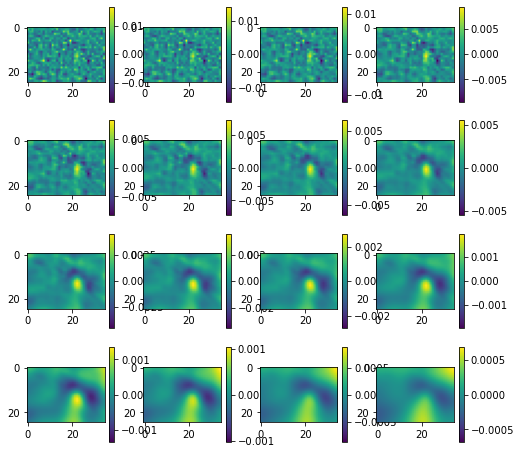

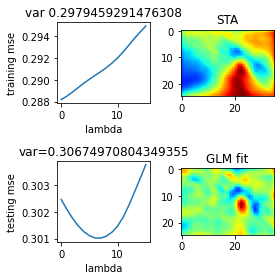

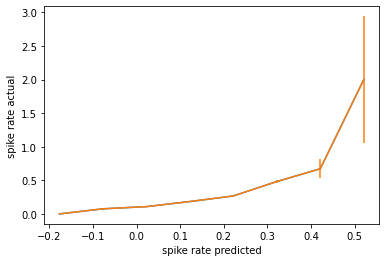

In [762]:
staPdf = PdfPages(name_base+'sta_ridge_all_50ms_0lag_corrected_gr.pdf')
lag_list = [0]
for celln in tqdm(range(1)):
    for lag_ind, lag in enumerate(lag_list):
        sps = np.roll(model_nsp[celln,:],-lag)
        sps = sps[use];
        nT = len(sps)
        test_frac = 0.2;
        ntest = int(nT*test_frac)
        x_train = x[ntest:,:]
        sps_train = sps[ntest:]
        x_test = x[:ntest,:]
        sps_test = sps[:ntest]

        sta = x_train.T@sps_train/np.sum(sps_train)
        crange = np.max(np.abs(sta[:-1]))
        #plt.imshow(np.reshape(sta[:-1],nks),vmin = -crange, vmax = crange); plt.title('sta')

        XXtr = x_train.T @ x_train;
        XYtr = x_train.T @sps_train;

        Imat = np.eye(nk);
        Imat = linalg.block_diag(Imat,np.zeros((nparams+1,nparams+1)))
        

        
        D  = linalg.block_diag(Dx.toarray(),np.zeros((nparams+1,nparams+1)))
        lambdas = 1024 * (2**np.arange(0,16))
        nlam = len(lambdas)

        msetrain = np.zeros((nlam,1))
        msetest = np.zeros((nlam,1))
        w_ridge = np.zeros((nk+nparams+1,nlam))

        plt.figure(figsize = (8,8))
        for l in range(len(lambdas)):
            #w = np.linalg.solve((XXtr + lambdas[l]*Imat), XYtr)  # equivalent of \ (left divide) in matlab
            w = np.linalg.solve((XXtr + lambdas[l]*D), XYtr)  # equivalent of \ (left divide) in matlab
            #w = np.linalg.solve((XXtr + lambdas[l]*(D + Imat)), XYtr)  # equivalent of \ (left divide) in matlab
            msetrain[l] = np.mean((sps_train - x_train@w)**2)
            msetest[l] = np.mean((sps_test - x_test@w)**2)

            w_ridge[:,l] = w;

            plt.subplot(4,4,l+1)
            crange = np.max(np.abs(w[:-(nparams+1)]))
            plt.imshow(np.reshape(w[:-(nparams+1)],nks),vmin = -crange,vmax = crange); plt.colorbar()

        # select best cross-validated lambda for RF
        best_lambda = np.argmin(msetest)
        
        if nparams>0:
            plt.figure()
            for l in range(len(lambdas)):
                #w = np.linalg.solve((XXtr + lambdas[l]*Imat), XYtr)  # equivalent of \ (left divide) in matlab
                w = np.linalg.solve((XXtr + lambdas[best_lambda]*D + lambdas[l]*Imat_params), XYtr)  # equivalent of \ (left divide) in matlab
                #w = np.linalg.solve((XXtr + lambdas[l]*(D + Imat)), XYtr)  # equivalent of \ (left divide) in matlab
                msetrain[l] = np.mean((sps_train - x_train@w)**2)
                msetest[l] = np.mean((sps_test - x_test@w)**2)

                w_ridge[:,l] = w;

                plt.subplot(4,4,l+1)
                plt.plot(w[-nparams:-1])

            best_lambda = np.argmin(msetest)
        ridge_rf = w_ridge[:,best_lambda]

        staPdf.savefig()
        
        plt.figure(figsize = (4,4))
        #plot training/testing error
        plt.subplot(2,2,1)
        plt.plot(msetrain);  plt.xlabel('lambda'); plt.ylabel('training mse'); plt.title('var ' +  str(np.var(sps_train)))
        plt.subplot(2,2,3)
        plt.plot(msetest); plt.xlabel('lambda'); plt.ylabel('testing mse'); plt.title('var=' + str(np.var(sps_test)))

        #plot sta (for comparison)
        plt.subplot(2,2,2)
        crange = np.max(np.abs(sta[:-(nparams+1)]))
        plt.imshow(np.reshape(sta[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        #plt.title('unit ' + str(celln)+ ' lag ' + str(lag))
        #plt.title('unit ' +  str(np.var(sps_train)))
        plt.title('STA')
        
        plt.subplot(2,2,4)
        crange = np.max(np.abs(ridge_rf[:-(nparams+1)]))
        plt.imshow(np.reshape(ridge_rf[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        #plt.title('var=' + str(np.var(sps_test)))
        plt.title('GLM fit')       

        plt.tight_layout()

        staPdf.savefig()

    plt.figure()
    binned_sp, bins, junk = stats.binned_statistic(x_test@ridge_rf, sps_test,'mean',8)
    binned_std, bins, junk = stats.binned_statistic(x_test@ridge_rf, sps_test,'std',8)
    binned_count, bins, junk = stats.binned_statistic(x_test@ridge_rf, sps_test,'count',8)
    #plt.plot(x_test@ridge_rf, sps_test,'.')
    plt.plot(bins[:-1],binned_sp)
    plt.errorbar(bins[:-1],binned_sp,binned_std/np.sqrt(binned_count))
    #plt.errorbar(bins[:-1],binned_sp,binned_std**2)
    plt.xlabel('spike rate predicted')
    plt.ylabel('spike rate actual')
    #plt.ylim(-1,1)
    #plt.hist(x_test@ridge_rf)
    staPdf.savefig()

    #plt.figure()
    #plt.hist(x_test@ridge_rf)
staPdf.close()

In [717]:
Imat_params = linalg.block_diag( np.zeros((nk,nk)), np.eye(nparams),0)
Imat_params


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

var = 55.258550539624466
err = 50.58458337772447


Text(0.5, 1.0, 'exp var = 0.0845836004791406')

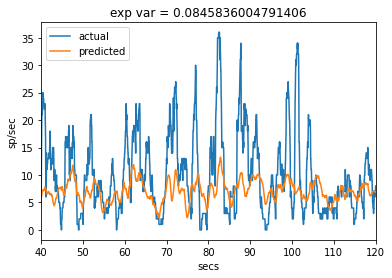

In [764]:
sp_smooth = (np.convolve(sps_test,np.ones(40),'same'))
pred_smooth = (np.convolve(x_test@ridge_rf,np.ones(40),'same'))
err = np.mean((sp_smooth-pred_smooth)**2)
print('var = '+ str(np.var(sp_smooth)))
print('err = ' + str(err))

maxt = 4800;
plt.plot(model_t[0:maxt],sp_smooth[0:maxt],label = 'actual')
plt.plot(model_t[0:maxt],pred_smooth[0:maxt],label='predicted')
plt.xlabel('secs'); plt.ylabel('sp/sec'); plt.legend(); plt.xlim([40,120])
expvar =(np.var(sp_smooth) - err)/np.var(sp_smooth) 
plt.title('exp var = ' + str(expvar))

In [697]:
np.corrcoef(sp_smooth,pred_smooth)
stats.spearmanr(pred_smooth,sp_smooth)

SpearmanrResult(correlation=0.37927881840345545, pvalue=0.0)

(0.0, 5.0)

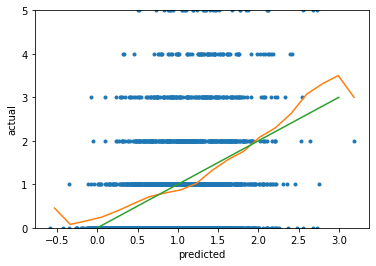

In [755]:
plt.plot(pred_smooth[::10],sp_smooth[::10],'.')
binned_sp,bins,junk = stats.binned_statistic(pred_smooth,sp_smooth,'mean',20)
plt.plot(0.5*(bins[:-1]+bins[1:]),binned_sp)
plt.xlabel('predicted'); plt.ylabel('actual')
plt.plot([0,3],[0,3])
plt.ylim([0,5])

Text(0.5, 1.0, 'dEye filter')

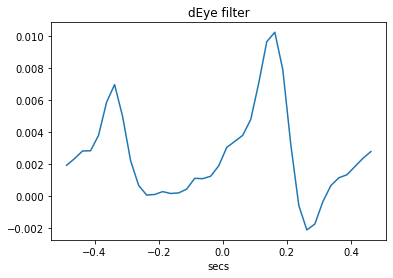

In [751]:
paramfit = ridge_rf[-40:-1]
plt.plot((np.arange(len(paramfit))-len(paramfit)/2)*model_dt,paramfit)
plt.xlabel('secs'); plt.title('dEye filter')

In [36]:
sta = np.zeros((60*80))
sta[goodpts[0]] = glm.beta_
sta = np.reshape(sta,(60,80))
climrange = np.max(np.abs(sta))
plt.imshow(sta,cmap = 'jet', vmin = -climrange, vmax = climrange ); plt.colorbar()

NameError: name 'glm' is not defined

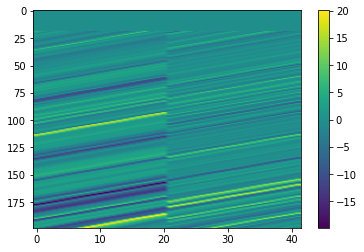

In [740]:
interval = 1;
nt = 20;
ngroup = 2;
eyeDesign = np.zeros((len(model_t),ngroup*(interval*nt+1)));
model_dth = np.diff(model_th)
for t in range(interval*nt,len(model_th)- interval*nt):  # use np.roll instead, with roll = -range : interval, range
    eyeDesign[t,:nt+1] =  model_dth[range(np.int(t-nt/2),np.int(t+nt/2+1)) ] - model_gz[range(np.int(t-nt/2),np.int(t+nt/2+1))] 
    eyeDesign[t,nt+1:2*(nt+1)] =  model_dth[range(np.int(t-nt/2),np.int(t+nt/2+1)) ] + model_gz[range(np.int(t-nt/2),np.int(t+nt/2+1))]
plt.imshow(eyeDesign[1:200,:],aspect = 'auto'); plt.colorbar()
eyeDesign[np.isnan(eyeDesign)] = 0
trange = np.array(range(np.int(-nt/2),np.int(nt/2+1)))

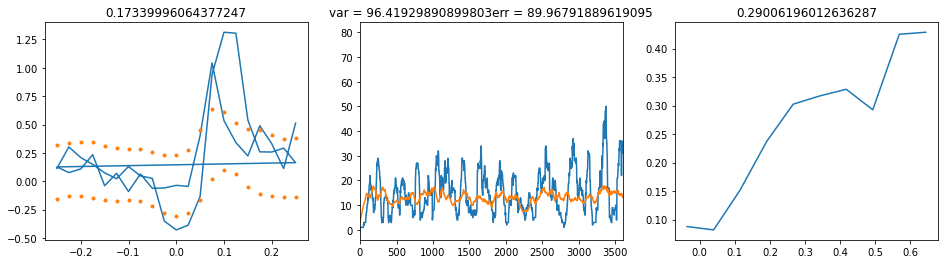

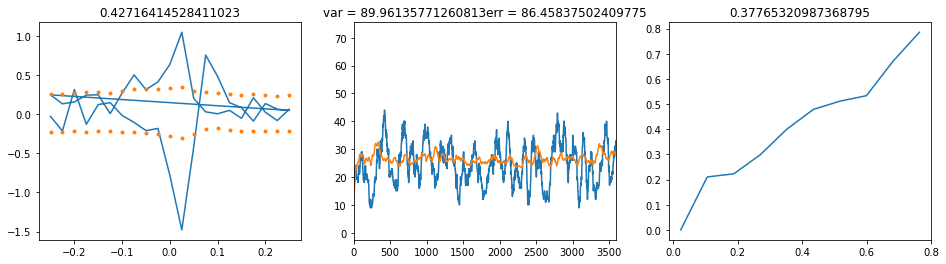

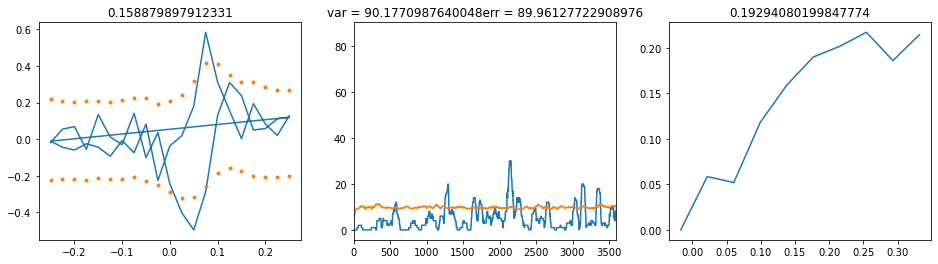

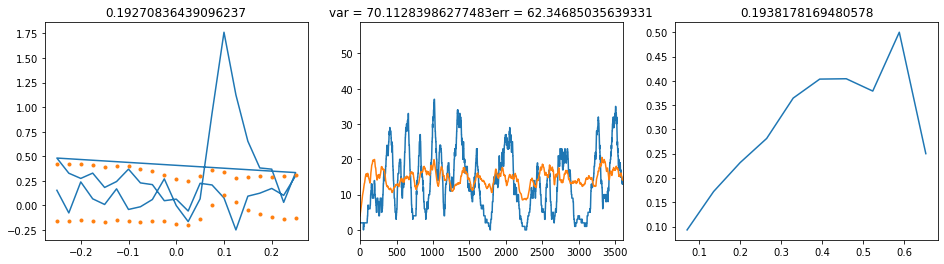

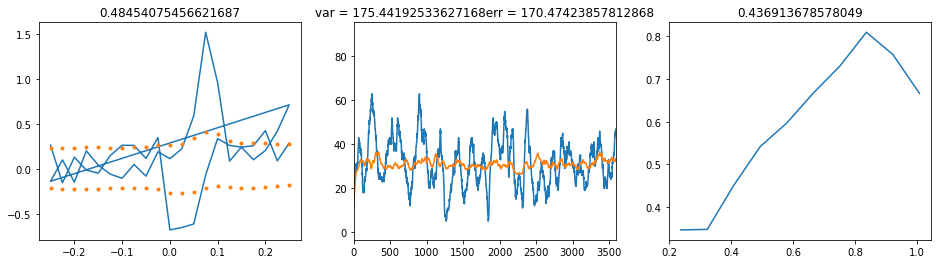

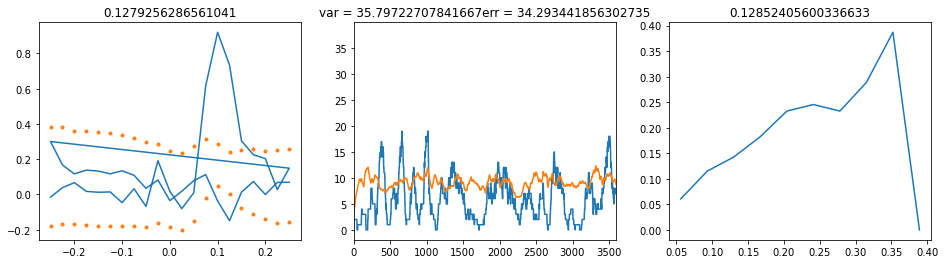

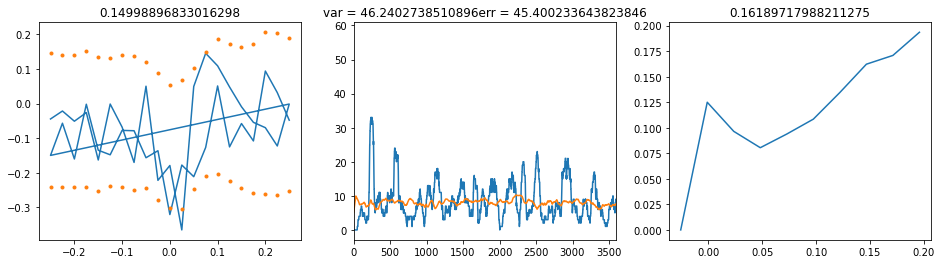

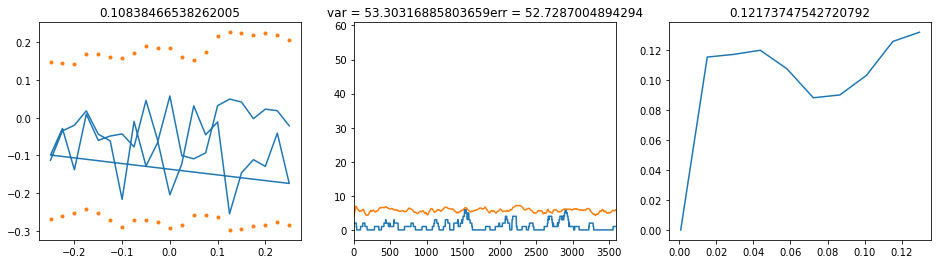

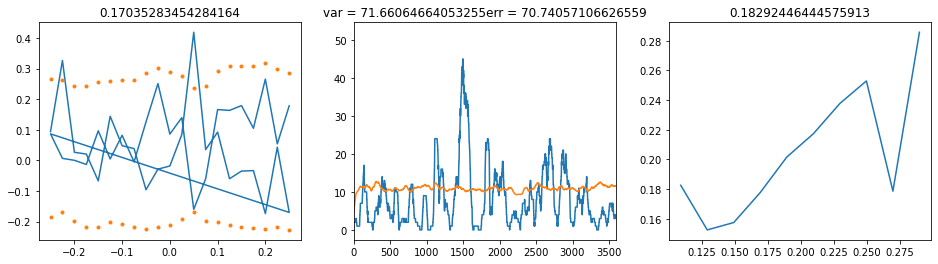

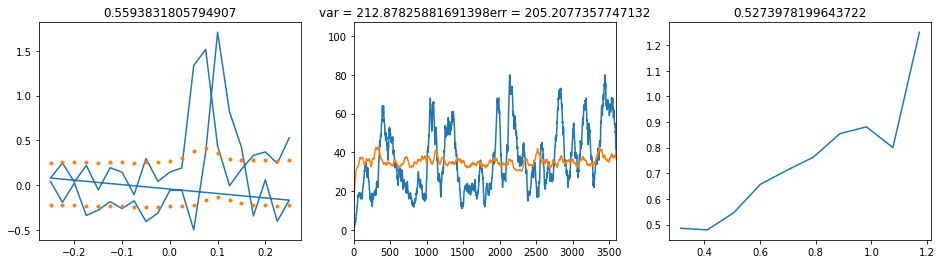

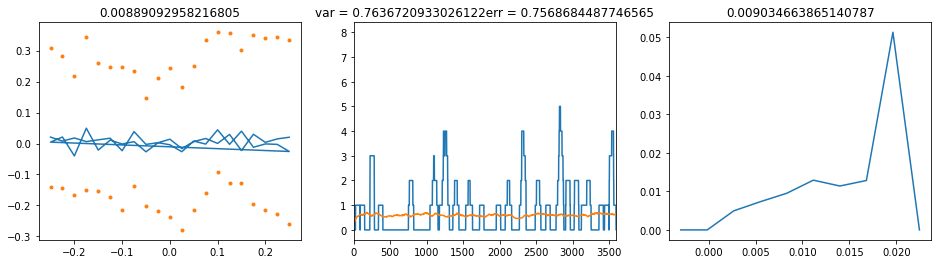

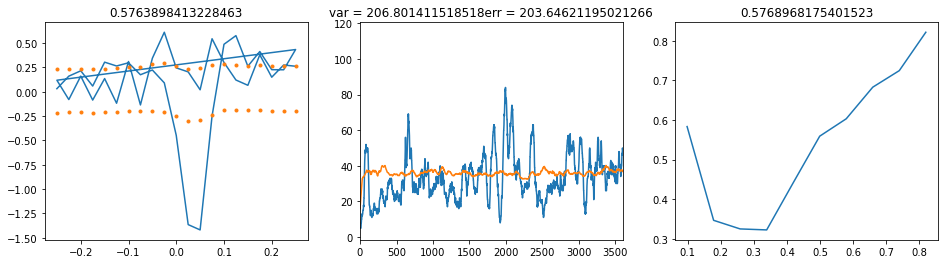

In [743]:
trangeAll = np.append(trange,trange)
for unit in range(n_units): 
    eyePos = eyeDesign.copy();   eyePos[eyePos<0]=0; #eyePos = (eyePos>3);
    eyePos = eyePos - np.mean(eyePos)
    eyePos = np.append(eyePos,np.ones((len(model_t),1)), axis = 1) # append column of ones
    sta_ridge = np.linalg.solve(eyePos.T@eyePos, eyePos.T@model_nsp[unit,:])
    plt.figure(figsize = (16,4))
    plt.subplot(1,3,1)
    plt.plot(-trangeAll*model_dt,sta_ridge[:-1]*100)
    sta= eyePos.T@model_nsp[unit,:]/np.sum(model_nsp[unit,:])  
    plt.plot(-trangeAll*model_dt,sta[:-1],'.')
    plt.title(str(np.mean(model_nsp[unit,:])))
    plt.subplot(1,3,2)
   # plt.plot(model_t,eyePos@sta_ridge); plt.plot(model_t,model_nsp[unit,:]);plt.xlim([1000,1010]);
   # plt.title(str(np.var(model_nsp[unit,:])))
    
    sp_smooth = (np.convolve(model_nsp[unit,:],np.ones(60),'same'))
    pred_smooth = (np.convolve(eyePos@sta_ridge,np.ones(60),'same'))
    err = np.mean((sp_smooth-pred_smooth)**2)
    plt.title('var = '+ str(np.var(sp_smooth))  + 'err = ' + str(err))


    plt.plot(sp_smooth)
    plt.plot(pred_smooth)
    plt.xlim(0,3600)
    
    plt.subplot(1,3,3)
    binned_rate, bins,junk = stats.binned_statistic(eyePos@sta_ridge,model_nsp[unit,:],'mean',10)
    plt.plot(bins[:-1],binned_rate); plt.title(str(np.mean((eyePos@sta_ridge - model_nsp[unit,:])**2)))
    
                                               
    #plt.ylim([-0.6,0.6])

In [ ]:
model_nsp[np.isnan(model_nsp)] = 0
eyeDesign[np.isnan(eyeDesign)] = 0

In [ ]:
c = 4
st_move = ((eyeDesign.T @ model_nsp[c,:]) / np.nansum(model_nsp[c,:])) # - np.mean(eyeDesign,axis=0)
plt.plot(st_move[1:])

In [ ]:
st_move

In [ ]:
c = 8
glm = GLM(distr='softplus', score_metric='pseudo_R2', reg_lambda=0.001, alpha = 0.05, max_iter=5000, verbose = True)

eyeDesign[np.isnan(eyeDesign)]=0
# fit the model on the training data
eyeNeg = eyeDesign.copy();
eyeNeg[eyeNeg>0]=0;
eyePos = eyeDesign.copy();
eyePos[eyeNeg<0]=0;

glm.fit(eyeDesign, model_nsp[c,:])
plt.plot(glm.beta_[1:])

In [ ]:
fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
lag = 0;
for c in tqdm(range(n_units)):
    sp = np.roll(model_nsp[c,:],lag)
    nonzero = np.where(sp>0)[0]
    ensemble = np.moveaxis(model_vid[nonzero,:,:],(0,1,2),(2,0,1)) * sp[nonzero]
    sta = np.nansum(ensemble,axis=2)/np.sum(sp)
    plt.subplot(np.ceil(n_units/4),4,c+1)
    plt.imshow(sta,vmin=-0.3,vmax=0.3,cmap = 'jet')

In [ ]:
junk

In [ ]:
#first, calculate mean STA for frames that meet eye criteria
# then, can subtract this off from each STA

goodcells['ensemble'] = np.nan
goodcells['ensemble'] = goodcells['ensemble'].astype(object)

staAll = np.zeros((n_units,np.shape(img_norm)[1],np.shape(img_norm)[2]))
lag = 0.0
fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
for c, ind in enumerate(goodcells.index):
    sta = 0; nsp = 0
    sp = goodcells.at[ind,'spikeT'].copy()

    ensemble = np.zeros((len(sp),np.shape(img_norm)[1],np.shape(img_norm)[2]))
    for s in tqdm(sp):
        if (s-lag >5) & ((s-lag) <np.max(worldT))  & (thInterp(s-lag)>0) & (np.abs(phiInterp(s-lag))<10):
            nsp = nsp+1
            im = movInterp(s-lag)
            ensemble[nsp-1,:,:] = im;
            sta = sta+im
    #goodcells.at[ind,'ensemble'] = ensemble
    plt.subplot(np.ceil(n_units/4),4,c+1)
    #plt.title(str(nsp))
    plt.title(f'ind={ind!s} nsp={nsp!s}')
    plt.axis('off')
    if nsp > 0:
        sta = sta/nsp - staNull
    else:
        sta = np.nan
    if pd.isna(sta) is True:
        plt.imshow(np.zeros([120,160]))
    else:
        plt.imshow((sta ),vmin=-0.6,vmax=0.6,cmap = 'jet')
        staAll[c,:,:] = sta
plt.tight_layout()

In [ ]:
plt.hist(phi,np.arange(-90,90,5))
np.sum((np.abs(th)<10) &(np.abs(phi)<10) ) /len(th)

In [ ]:
lagRange = np.arange(-0.05,0.2,0.05)
fig = plt.figure(figsize = (12,2*n_units))
for c, ind in enumerate(goodcells.index):
    sp = goodcells.at[ind,'spikeT'].copy()
    for  lagInd, lag in enumerate(lagRange):
        sta = 0; nsp = 0
        for s in tqdm(sp):
            if (s-lag >5) & ((s-lag) <np.max(worldT))  & (np.abs(thInterp(s-lag))<10) & (np.abs(phiInterp(s-lag))<10):
                nsp = nsp+1
                sta = sta+movInterp((s-lag))
        plt.subplot(n_units,6,(c*6)+lagInd + 1)
        if nsp > 0:
            sta = sta/nsp
        else:
            sta = np.nan
        if pd.isna(sta) is True:
            plt.imshow(np.zeros([120,160]))
        else:
            plt.imshow(sta,vmin=-0.4,vmax=0.4,cmap = 'jet')
        # plt.title(str(c) + ' ' + str(np.round(lag*1000)) + 'msec')
        if c == 0:
            plt.title(str(np.round(lag*1000)) + 'msec')
        plt.axis('off')
plt.tight_layout()


In [ ]:
stop here

In [ ]:
# get worldcam correction based on eye-movement vs frameshift regression
if free_move:
    print('getting worldcam correction')
    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_EUCLIDEAN
    max_frames = 60*60
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);omegashift = np.zeros(max_frames)
    # get shift between adjacent frames
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
        xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]
        omegashift[i] = np.arctan2(warp_matrix[0,1],warp_matrix[0,0])

In [ ]:
plt.plot(worldT[0:max_frames],np.cumsum(omegashift*180/3.14))
plt.plot(eyeT[0:max_frames], omega[0:max_frames]-8)
plt.xlim([30,40])

In [ ]:
plt.plot(eyeT[0:max_frames],omega[0:max_frames])
plt.xlim([15,20])

In [ ]:
#correct movie
max_frames = 60*60
thInterp =interp1d(eyeT,th, bounds_error = False, fill_value = 0)
phiInterp =interp1d(eyeT,phi, bounds_error = False, fill_value = 0)

world_fix = np.zeros((max_frames, np.size(world_vid,1), np.size(world_vid,2)),'uint8')
for f in tqdm(range(max_frames)):
    t = worldT[f]
    thInt = thInterp(t)
    if np.isnan(thInt):
        thInt =0
    phiInt = phiInterp(t) 
    if np.isnan(phiInt):
        phiInt =0

    world_fix[f,:,:]= imshift(world_vid[f,:,:],(-(thInt*ymap[0] + phiInt*ymap[1]),-(thInt*xmap[0] + phiInt*xmap[1])))



In [ ]:
#compare alignement pre and post correction
number_of_iterations = 5000
termination_eps = 1e-4
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
warp_mode = cv2.MOTION_TRANSLATION
cc_fix = np.zeros(max_frames); xshift_fix = np.zeros(max_frames); yshift_fix = np.zeros(max_frames);
for i in tqdm(range(max_frames-1)):
    try:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (cc_fix[i], warp_matrix) = cv2.findTransformECC (world_fix[i,:,:],world_fix[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
        xshift_fix[i] = warp_matrix[0,2]; yshift_fix[i] = warp_matrix[1,2]
    except:
        xshift_fix[i] = np.nan; yshift_fix[i] = np.nan # very rarely, a frame will raise cv2 error when iterations do not converge for transform

if free_move:
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(xshift,label = 'x pre alignment')
    plt.plot(xshift_fix,label = 'x post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

    plt.subplot(2,1,2)
    plt.plot(yshift,label = 'y pre alignment')
    plt.plot(yshift_fix, label = 'y post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

    diagnostic_pdf.savefig()
    plt.close()



In [ ]:
# get optic flow pre/post correction
max_frame = 60*60
flow = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
flow_fix = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
x,y = np.meshgrid(np.arange(0, np.size(world_vid,2)), np.arange(0,np.size(world_vid,1)))
vidfile = os.path.join(file_dict['save'], (file_dict['name']+'_flowfix.mp4'))

print('plotting video of optical flow')
fig, axs = plt.subplots(1,2,figsize = (16,8))
# now animate
writer = FFMpegWriter(fps=30)
nx = 5
with writer.saving(fig, vidfile, 100):
    for f in tqdm(range(max_frame-1)):

        flow[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_vid[f,:,:],world_vid[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[0].cla()
        axs[0].imshow(world_vid[f,:,:],vmin = 0, vmax = 255)
        u = flow[f,:,:,0]; v = flow[f,:,:,1]
        axs[0].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )

        flow_fix[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_fix[f,:,:],world_fix[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[1].cla()
        axs[1].imshow(world_fix[f,:,:],vmin = 0, vmax = 255)
        u = flow_fix[f,:,:,0]; v = flow[f,:,:,1]
        axs[1].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )

        writer.grab_frame()